In [ ]:
# !! pip install fastai

In [ ]:
# ones = u.read_ones(data_path / 'train.csv')
# u.add_more_time(ones)
# ones = ones.rename(columns={'sid': 'segment_id', 'day': 'weekday'})

# vehinj = u.read_vehinj(Path('../data/SANRAL_v2'))

# x_cols = cols
# x_cols.extend([c for c in train.columns if c.startswith('hist_')])

# train = u.select_by_time(train_full, '2016-01-01', val_tstart, time_col='datetime')
# val = u.select_by_time(train_full, val_tstart, '2019-01-01', time_col='datetime')

# def prepare(df):
#     df[cat_cols] = df[cat_cols].replace(np.nan, 'NAN').astype('object')
#     df[cat_cols] = df[cat_cols].astype('str')
    

# prepare(train_full)
# prepare(test)

# val = train_full.loc[ids_val]
# val.reset_index(inplace=True)

# u.run_many_th_experiment(val, np.array(predictions), th_score=0.12)

# train_full = train_full[train_full.datetime < pd.Timestamp('2018-04-01')]  # Only for fast debug
# train_full.reset_index(inplace=True)


In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from fastai.tabular import *
from fastai.callbacks.tracker import EarlyStoppingCallback, SaveModelCallback
from pathlib import Path
import src.data_utils as u
import src.fai_utils as fu
from tqdm.auto import tqdm
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.nn import CrossEntropyLoss as CEloss

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 100)

u.random_seed(42)

data_path = Path('../data')

In [2]:
train_full, test, all_cols, cont_cols, cat_cols = u.read_data(data_path)

In [3]:
for f in cont_cols:
    test[f] = test[f].fillna(0)
    train_full[f] = train_full[f].fillna(0)

# Fast ai

# 1 FOLD VALID

In [4]:
field_combs = [
    tuple([('segment_id')]), tuple(['hour']), tuple(['weekday']), tuple(['month']),
    ('segment_id', 'hour'), ('segment_id', 'weekday'), ('segment_id', 'month'), ('weekday', 'month'), ('hour', 'weekday'),
    ('segment_id', 'weekday', 'hour'), ('segment_id', 'weekday', 'month')
]

ones = u.read_ones('../data/train.csv')
ones['segment_id'] = ones['sid']
u.add_more_time(ones)

train = u.select_by_time(train_full, '2017-01-01', '2018-10-01', 'datetime')
u.add_statistic(data=train, stat_data=ones,
                field_combs=field_combs, prefix='hist_',
                tstart='2016-01-01', tend='2017-01-01',
               )

val = u.select_by_time(train_full, '2018-10-01', '2019-01-01', 'datetime')
u.add_statistic(data=val, stat_data=ones,
                field_combs=field_combs, prefix='hist_',
                tstart='2016-01-01', tend='2018-10-01',
               )

u.add_statistic(data=test, stat_data=ones,
                field_combs=field_combs, prefix='hist_',
                tstart='2016-01-01', tend='2019-01-01',
               )


hist_cols = list(filter(lambda x: x.startswith('hist_'), train.columns.values))

all_cols += hist_cols
cont_cols += hist_cols

Time data was added.
Statistic appending:



Statistic data was added added.
Statistic appending:



Statistic data was added added.
Statistic appending:



Statistic data was added added.


In [5]:
train_full = pd.concat([train, val])

In [6]:
val_ids = (train_full.datetime >= pd.Timestamp('2018-10-01')).values

In [7]:
procs = [FillMissing, Categorify, Normalize]

test_tab = TabularList.from_df(df=test, cat_names=cat_cols, cont_names=cont_cols)

In [8]:
p = {
    'bs': 200_000,
    'n_epochs': 20,
    'layers': [512, 256, 128],
    'weights': [1, 10],
    'n_steps_f1': 20,
    'emb_drop': 0.5
}

In [9]:
data = (TabularList.from_df(
            train_full, procs=procs, cat_names=cat_cols, cont_names=cont_cols)
                 .split_by_idx(val_ids)
                 .label_from_df(cols='y')
                 .add_test(test_tab)
                 .databunch(bs=p['bs']))

In [10]:
work_dir = '../results/fai/'
Path(work_dir).mkdir(exist_ok=True, parents=True)
print(work_dir)
    
with open(Path(work_dir) / 'parameters.json', 'w') as f:
    json.dump(p, f)
        
learn = tabular_learner(data, path=work_dir, layers=p['layers'],
                                emb_drop=p['emb_drop'],
                                metrics=u.F1(0, 1, steps=p['n_steps_f1']),
                                callback_fns=[ShowGraph,
                                              partial(EarlyStoppingCallback,
                                                      monitor='f1',
                                                      min_delta=0.001,
                                                      patience=7)
                                              ],
                                loss_func=CEloss(
                                    weight=tensor(p['weights']).float().cuda()
                                ),
                                opt_func=torch.optim.Adam
                                )

../results/fai/


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


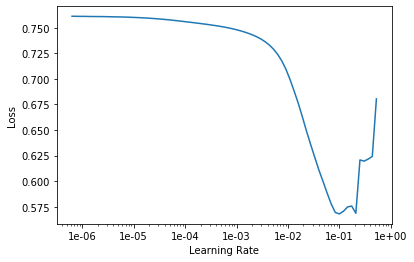

In [11]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,f1,time
0,0.707606,0.669284,0.101315,01:41
1,0.539742,0.288154,0.123976,01:42
2,0.280143,0.157103,0.124641,01:44
3,0.175907,0.157769,0.129654,01:47
4,0.135578,0.153718,0.131949,01:43
5,0.119182,0.149220,0.138936,01:42
6,0.111916,0.146505,0.142241,01:45
7,0.108202,0.144443,0.148910,01:41
8,0.106254,0.142620,0.149773,01:44
9,0.104451,0.139947,0.151768,01:45


/home/AlekseySh/miniconda3/envs/neuro/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


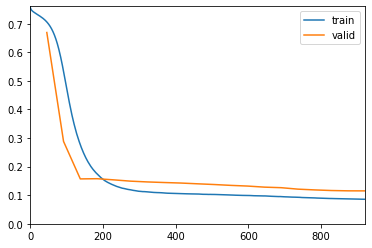

Better model found at epoch 0 with f1 value: 0.10131474516028849.
Better model found at epoch 1 with f1 value: 0.12397614835200838.
Better model found at epoch 2 with f1 value: 0.12464088397790055.
Better model found at epoch 3 with f1 value: 0.129653639562882.
Better model found at epoch 4 with f1 value: 0.13194949428174785.
Better model found at epoch 5 with f1 value: 0.13893591293833132.
Better model found at epoch 6 with f1 value: 0.14224108426312546.
Better model found at epoch 7 with f1 value: 0.14891011511143767.
Better model found at epoch 8 with f1 value: 0.14977279612238717.
Better model found at epoch 9 with f1 value: 0.15176797775129125.
Better model found at epoch 10 with f1 value: 0.15859351318581388.
Better model found at epoch 11 with f1 value: 0.16672543902955075.
Better model found at epoch 12 with f1 value: 0.1667757417102967.
Better model found at epoch 13 with f1 value: 0.1805903916650588.
Better model found at epoch 14 with f1 value: 0.19058823529411764.
Better mo

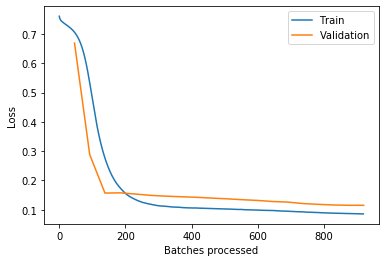

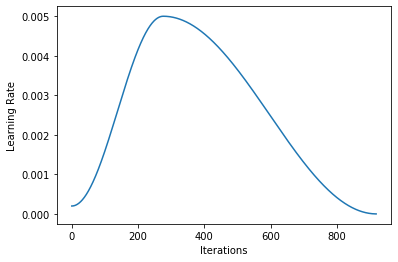

In [12]:
learn.fit_one_cycle(p['n_epochs'], max_lr=slice(5e-3),
                    callbacks=[
                        SaveModelCallback(learn, every='improvement',
                                          monitor='f1', name='best')])
                        
learn.recorder.plot_losses()                        
learn.recorder.plot_lr()
plt.show()

# Cross VALID

In [14]:
probas_val = probas_val[:, 1]

In [ ]:
def get_folds(train):
    # months = ['01', '03', '06', '09', '12']
    months = ['09', '12']
    
    folds = []
    for i_fold in range(len(months) - 1):
        tstart = pd.Timestamp('2018-' + months[i_fold] + '-01')
        tend = pd.Timestamp('2018-' + months[i_fold + 1] + '-01')

        tt = train.datetime
        ids_val = ((tstart <=  tt) & (tt < tend)).to_numpy().nonzero()[0]
        folds.append(ids_val)
    
    return folds
        
    
folds = get_folds(train_full)

# Submit

In [57]:
probas_val, *_ = learn.get_preds(DatasetType.Valid)
probas_test, *_ = learn.get_preds(DatasetType.Test)

probas_val = probas_val[:, 1]
probas_test = probas_test[:, 1]

/home/AlekseySh/miniconda3/envs/neuro/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



f1 score  0.2195 
 recall 0.2383 
 precision 0.2035 
 th  0.5263 
 events  pred 7938 
 events true 6776


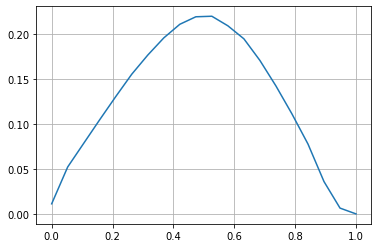

In [58]:
th = u.estimate(learn, val, y_true=val.y)

In [65]:
pred = np.array(probas_test) > th * .95

n_pred = sum(pred)
print(n_pred)

9243


In [66]:
submit = pd.DataFrame(
    data={'datetime x segment_id': test['datetime x segment_id'].values,
          'prediction': pred.astype(int)}
)

In [67]:
submit.to_csv(f'../results/submit_fai_{n_pred}.csv', index=False)